In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, convolve, median_filter
import pm
from typing import Iterable, Tuple, List, Dict, Callable, Any, Optional

In [23]:
images: List[np.ndarray] = [
    cv2.imread('data/fontanna1.jpg', cv2.IMREAD_GRAYSCALE), 
    cv2.imread('data/fontanna2.jpg', cv2.IMREAD_GRAYSCALE),
    cv2.imread('data/budynek1.jpg', cv2.IMREAD_GRAYSCALE),
    cv2.imread('data/budynek2.jpg', cv2.IMREAD_GRAYSCALE),
    cv2.imread('data/eiffel1.jpg', cv2.IMREAD_GRAYSCALE),
    cv2.imread('data/eiffel2.jpg', cv2.IMREAD_GRAYSCALE),
]

In [4]:
positions: np.ndarray = np.zeros((256, 4), dtype=np.int32)
with open('data/orb_descriptor_positions.txt', 'rb') as f:
    for idx, line in enumerate(f):
        positions[idx, :] = np.array([float(x) for x in line.split()]).astype(np.int32)


Harris method

In [5]:
def harris_matrix(
        gray_image: np.ndarray,
        gaussian_blur_size: int,
        sobel_kernel_size: int,
        k: float =.05,
        normalize: bool = True
) -> np.ndarray:
    s_x = cv2.Sobel(gray_image, cv2.CV_32F, 1, 0, ksize=sobel_kernel_size)
    s_y = cv2.Sobel(gray_image, cv2.CV_32F, 0, 1, ksize=sobel_kernel_size)

    s_xx = cv2.GaussianBlur(s_x * s_x, (gaussian_blur_size, gaussian_blur_size), 0)
    s_yy = cv2.GaussianBlur(s_y * s_y, (gaussian_blur_size, gaussian_blur_size), 0)
    s_xy = cv2.GaussianBlur(s_x * s_y, (gaussian_blur_size, gaussian_blur_size), 0)

    H = s_xx * s_yy - s_xy * s_xy - k * (s_xx + s_yy) ** 2
    
    return H / H.max() if normalize else H


def find_max(
        image : np.ndarray, 
        mask_size : int, 
        threshold: float
    ) -> Tuple[np.ndarray, np.ndarray]:
    data_max = maximum_filter(image, mask_size)
    maxima = (image==data_max)
    diff = image>threshold
    maxima[diff == 0] = 0
    return np.nonzero(maxima)


def harris_method(
        gray_image: np.ndarray,
        gaussian_blur_size: int = 7,
        sobel_kernel_size: int = 7,
        maximum_filter_size: int = 7,
        k: float =.05,
        threshold: float = 0.5,
        normalize: bool = True
) -> np.ndarray:
    H = harris_matrix(gray_image, gaussian_blur_size, sobel_kernel_size, k, normalize)
    return find_max(H, maximum_filter_size, threshold)

Characteristic Points

In [6]:
def characteristic_points_description(
        image: np.ndarray,	
        characteristic_points: np.ndarray,
        window_size: int = 15,
        processing_function: Callable[[np.ndarray], np.ndarray] = lambda x: (x - x.mean()) / x.std()
) -> List[Tuple[np.ndarray, Tuple[int, int]]]:
    s = window_size//2
    Y, X = image.shape
    points = list(filter(lambda p: s <= p[0]< Y-s and s <= p[1] < X-s, zip(characteristic_points[0], characteristic_points[1])))
    neighbours = [processing_function(image[point[0]-s:point[0]+s+1, point[1]-s:point[1]+s+1].flatten()) for point in points]
    coordinates = [point for point in points]
    return list(zip(neighbours, coordinates))

In [7]:
mae = lambda x, y: np.abs(x - y).mean()
mse = lambda x, y: ((x - y) ** 2).mean()
inner_product = lambda x, y: -(x * y).sum()/((x**2).sum()**.5 * (y**2).sum()**.5)
hamming = lambda x, y: (x != y).sum()

In [38]:
def charateristic_points_comparison(
    points_1: List[Tuple[np.ndarray, Tuple[int, int]]],
    points_2: List[Tuple[np.ndarray, Tuple[int, int]]],
    most_similar_descriptions: int = 20,
    measure: Callable[[np.ndarray, np.ndarray], float] = lambda x, y: np.linalg.norm(x-y),
    with_replacement: bool = False
):
    if with_replacement:
        distances = np.zeros((len(points_1), len(points_2)))
        for i, p1 in enumerate(points_1):
            for j, p2 in enumerate(points_2):
                distances[i, j] = measure(p1[0], p2[0])
        pairs = []
        while len(pairs) < most_similar_descriptions:
            argmin = np.unravel_index(distances.argmin(), distances.shape)
            pairs.append((distances[argmin], points_1[argmin[0]][1], points_2[argmin[1]][1]))
            distances[argmin[0], :] = np.inf
            distances[:, argmin[1]] = np.inf
        return pairs

    else:
        return sorted(
            [
                (measure(p1[0], p2[0]), p1[1], p2[1])
                for p1 in points_1
                for p2 in points_2
            ],
            key=lambda x: x[0]
        )[:most_similar_descriptions]

ORB

In [9]:
mask = np.array([
    [0,0,1,1,1,0,0],
    [0,1,0,0,0,1,0],
    [1,0,0,0,0,0,1],
    [1,0,0,0,0,0,1],
    [1,0,0,0,0,0,1],
    [0,1,0,0,0,1,0],
    [0,0,1,1,1,0,0],
])
x = np.array([-3,-3,-3,-2,-1,0,1,2,3,3,3,2,1,0,-1,-2])
y = np.array([-1,0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2])



In [10]:
def non_max_surpression(
        tested_points: List[Tuple[np.ndarray, Tuple[int, int]]], 
        distance_threshold: int = 20, 
        max_output_count: int = 100
        ) -> List[Tuple[int, int]]:
    semi_tested_points = sorted(tested_points, key=lambda x: x[0])
    active = np.ones(len(semi_tested_points), dtype=bool)
    taken: int = 0
    for i, point1 in enumerate(semi_tested_points):
        if taken >= max_output_count: break
        if active[i]:
            for j, point2 in enumerate(semi_tested_points[i+1:], start=i+1):
                if max(np.abs(point1[1][0] - point2[1][0]), np.abs(point1[1][1] - point2[1][1])) < distance_threshold:
                    active[j] = False

    return sorted([point[1] for i, point in enumerate(semi_tested_points) if active[i]], key=lambda x: x[0])[:max_output_count]

In [11]:

def FASTdetector(
        image: np.ndarray,
        x: np.ndarray,
        y: np.ndarray,
        mask_dim: float = 7,
        consecutive_pixels_count: int = 9,
        distance_threshold: int = 3,
        threshold: int = 10,
        max_output_count: int = 100
) -> List[Tuple[int, int]]:

    predicate: Callable[[np.ndarray], bool] = lambda c: c.sum() >= consecutive_pixels_count and np.max(convolve(c, kernel, mode='wrap'))>=consecutive_pixels_count
    s = mask_dim//2
    h = s//2

    kernel = np.zeros_like(x, dtype=np.int32)
    kernel[:consecutive_pixels_count] = 1

    r = image[h+1:-h, :-s]
    l = image[h+1:-h, s:]
    b = image[:-s, h+1:-h]
    t = image[s:, h+1:-h]
    m = image[h+1:-h, h+1:-h]
    
    H = harris_matrix(image, 7, 7, .05, True)

    median = np.median(np.stack([r, l, b, t], axis=2), axis=2)
    non_zero = np.nonzero(np.bitwise_or(median > m + threshold, median < m - threshold))
    points = list(zip(non_zero[0], non_zero[1]))
    
    semi_tested_points: List[Tuple[float, Tuple[int]]] = []

    for point in points:
        consecutive = image[x+point[0], y+point[1]]
        u = consecutive > m[point[0], point[1]] + threshold
        d = consecutive < m[point[0], point[1]] - threshold
        if predicate(u.astype(np.int32)) or predicate(d.astype(np.int32)):
            semi_tested_points.append((H[point[0], point[1]], point))

    return non_max_surpression(semi_tested_points, distance_threshold, max_output_count)

    
def centroid_descriptor(
    image: np.ndarray,
    characteristic_point: np.ndarray,
    window_size: int = 7,
):
    m = cv2.moments(image[characteristic_point[0]-window_size//2:characteristic_point[0]+window_size//2+1, characteristic_point[1]-window_size//2:characteristic_point[1]+window_size//2+1])
    return (m['m10']/m['m00'], m['m01']/m['m00']), np.arctan2(m['m01'], m['m10'])


def BRIEFdescriptor(
    image: np.ndarray,
    characteristic_points: List[np.ndarray],
    pairs: np.ndarray,
    window_size: int = 31,
    gauss_window_size: int = 5,
):
    s = window_size//2
    is_inside = lambda p: s <= p[0] < image.shape[0]-s and s <= p[1] < image.shape[1]-s
    result = []
    for characteristic_point in filter(is_inside, characteristic_points):
        try:
            centroid, phase = centroid_descriptor(image, characteristic_point)
            roi: np.ndarray = image[characteristic_point[0]-s:characteristic_point[0]+s+1, characteristic_point[1]-s:characteristic_point[1]+s+1]
            blurred = cv2.GaussianBlur(roi, (gauss_window_size, gauss_window_size), 0)
            pairs[:, :2] = (pairs[:, :2] @ np.array([[np.cos(phase), -np.sin(phase)], [np.sin(phase), np.cos(phase)]])).astype(np.int32)
            
            result.append(((blurred[pairs[:, 0], pairs[:, 1]] < blurred[pairs[:, 2], pairs[:, 3]]).astype(np.int32), characteristic_point))
        except IndexError:
            pass
    return result


    

Images Matching

In [ ]:
def image_matching(
    image_1: np.ndarray,
    image_2: np.ndarray,
    best_points_count: int = 10,
    descriptor: Callable[[None], Any] = cv2.SIFT_create,
    norm: int = cv2.NORM_L2,
    use_knn_match: bool = False,
):
    descriptor = descriptor()
    keypoints_l, des1 = descriptor.detectAndCompute(image_1, None)
    keypoints_r, des2 = descriptor.detectAndCompute(image_2, None)
    matcher = cv2.BFMatcher(norm, crossCheck=True)
    if use_knn_match:
        matched = matcher.knnMatch(des1, des2, k=2)
        best_matches = [ [m] for m,n in matched if m.distance < 0.5*n.distance]
    else:
        matched = matcher.match(des1, des2)
        best_matches = sorted(matched, key=lambda x: x.distance)[:best_points_count]

    keypointsL = np.float32([kp.pt for kp in keypoints_l])
    keypointsR = np.float32([kp.pt for kp in keypoints_r])

    ptsA = np.float32([keypointsL[m.queryIdx] for m in best_matches])
    ptsB = np.float32([keypointsR[m.trainIdx] for m in best_matches])

    H = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 4.0)[0]
    result = cv2.warpPerspective(image_1, H, (image_1.shape[1] + image_2.shape[1],max(image_1.shape[0], image_2.shape[0])))
    result[0:image_2.shape[0], 0:image_2.shape[1]] = image_2
    return result

Tests


In [25]:
def compare_images(image_1: np.ndarray, image_2: np.ndarray) -> None:
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image_1, cmap='gray')
    plt.plot(*reversed(harris_method(image_1)), 'r*')
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image_2, cmap='gray')
    plt.plot(*reversed(harris_method(image_2)), 'r*')
    plt.axis("off")
    plt.show()

In [33]:
def compareORB(
        image_1: np.ndarray,
        image_2: np.ndarray,
) -> None:
    x = np.array([-3,-3,-3,-2,-1,0,1,2,3,3,3,2,1,0,-1,-2])
    y = np.array([-1,0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2])

    compared = charateristic_points_comparison(
                    BRIEFdescriptor(image_1, FASTdetector(image_1, x, y, threshold=50), positions),
                    BRIEFdescriptor(image_2, FASTdetector(image_2, x, y, threshold=50), positions),
                    10,
                    measure=hamming,
                    with_replacement=True
            ) 
    plt.figure(figsize=(15, 15))
    plt.imshow(pm.appendimages(image_1, image_2), cmap='gray')
    for _, (y1, x1), (y2, x2) in compared:
            plt.plot([x1, x2 + image_1.shape[1]], [y1, y2], 'r', linewidth=0.5)
    plt.axis('off')
    plt.show()

In [21]:
def match_characteristic_points(
        image_1: np.ndarray,
        image_2: np.ndarray,	
        
        measure: Callable[[np.ndarray, np.ndarray], float] = lambda x, y: np.linalg.norm(x-y)
) -> None:
        compared = charateristic_points_comparison(
                characteristic_points_description(image_1, harris_method(image_1)),
                characteristic_points_description(image_2, harris_method(image_2)),
                10,
                measure=measure
        ) 
        plt.figure(figsize=(15, 15))
        plt.imshow(pm.appendimages(image_1, image_2))
        for _, (y1, x1), (y2, x2) in compared:
                plt.plot([x1, x2 + image_1.shape[1]], [y1, y2], 'r', linewidth=0.5)
        plt.axis('off')
        plt.show()

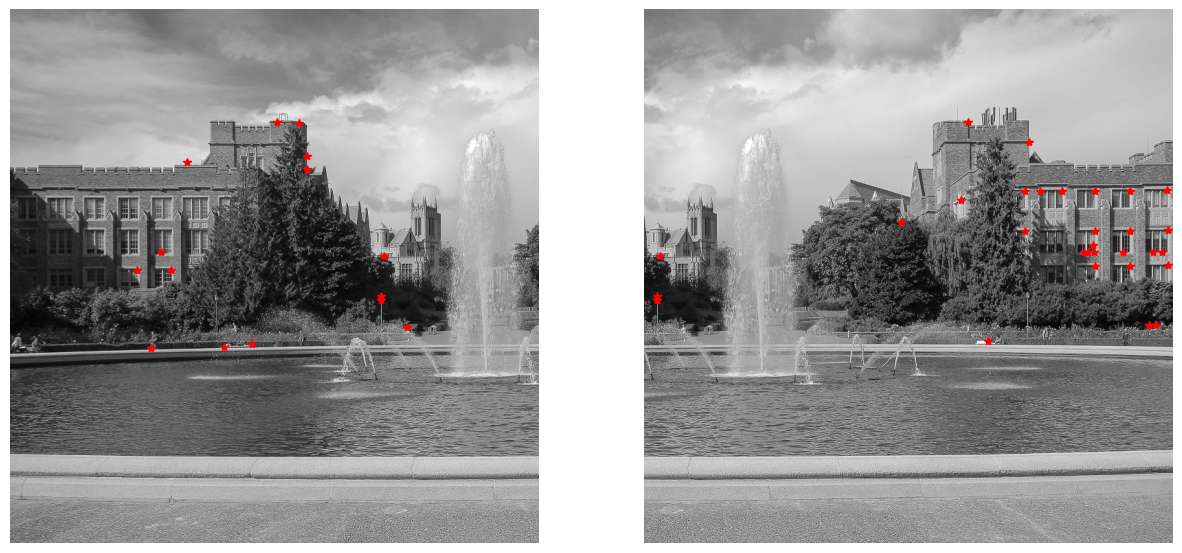

In [ ]:
compare_images(images[0], images[1])

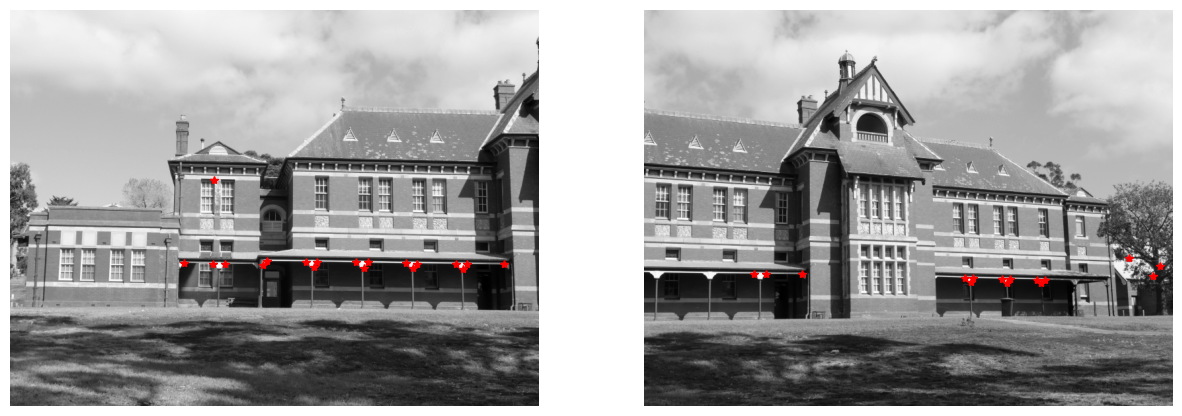

In [26]:
compare_images(images[2], images[3])

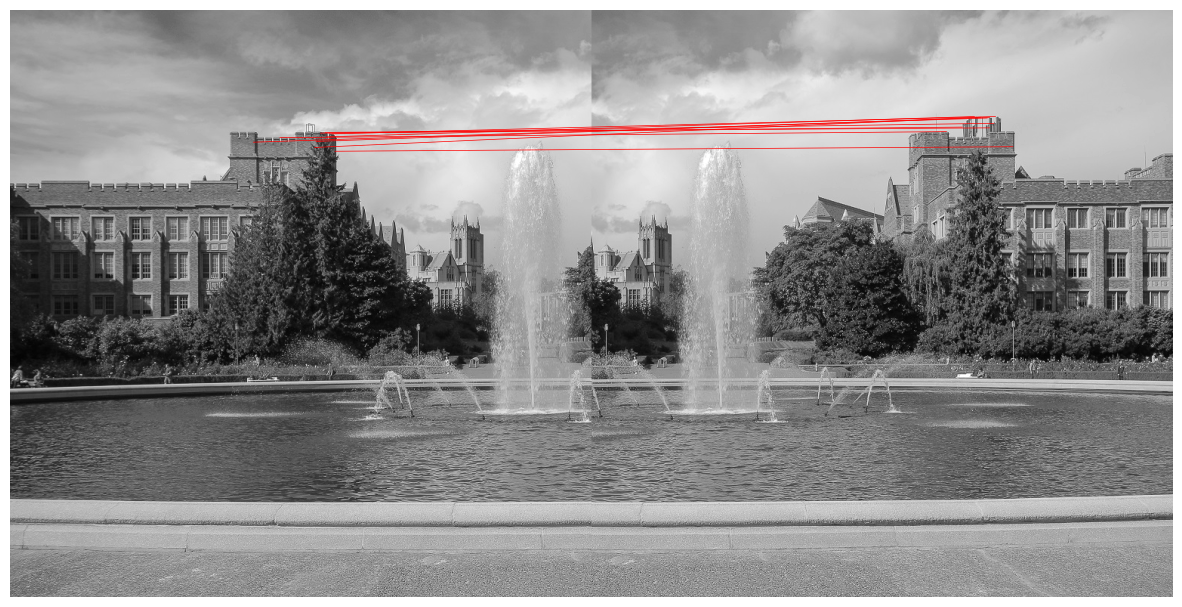

In [39]:
compareORB(images[0], images[1])

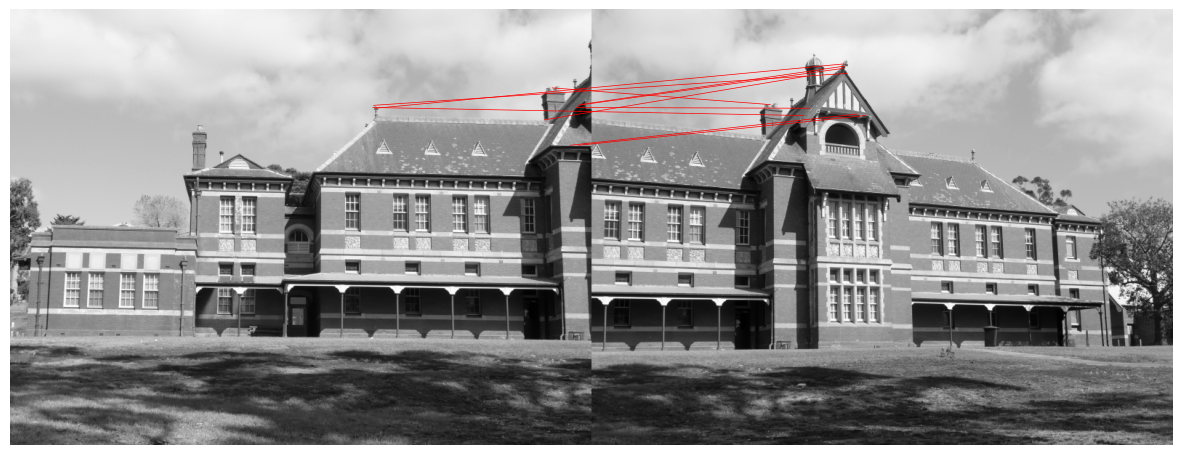

In [40]:
compareORB(images[2], images[3])

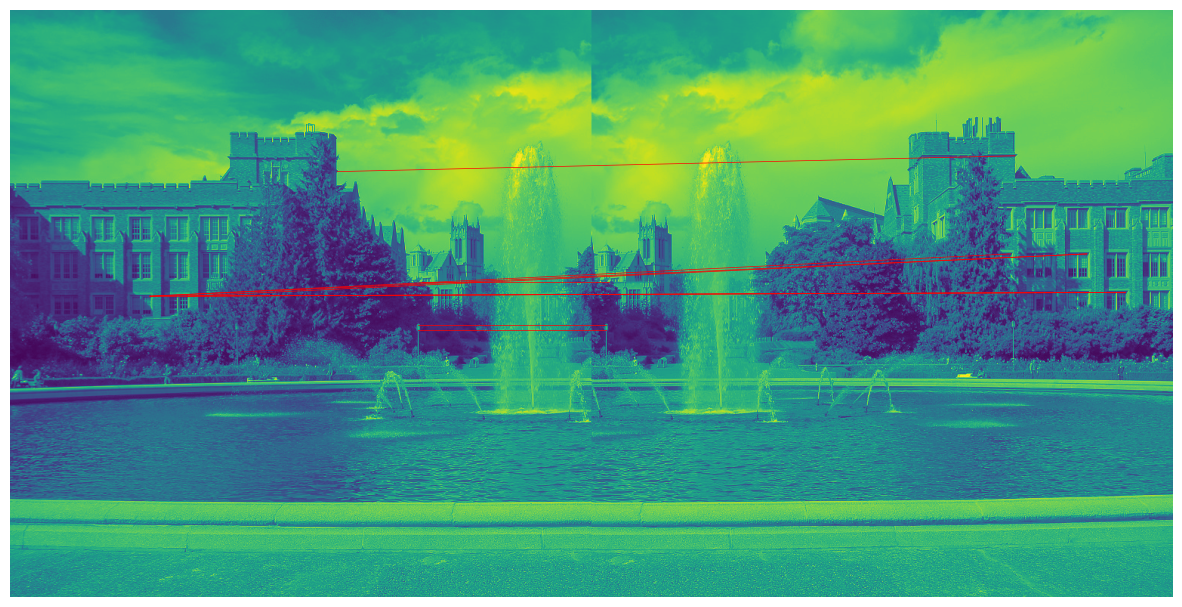

In [ ]:
match_characteristic_points(images[0], images[1], measure=inner_product)

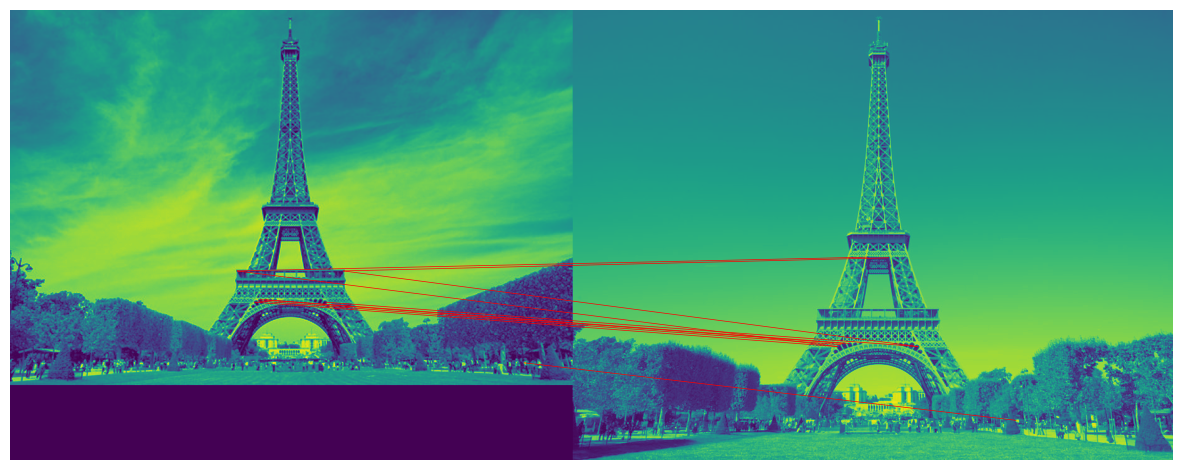

In [ ]:
match_characteristic_points(images[4], images[5], measure=inner_product)

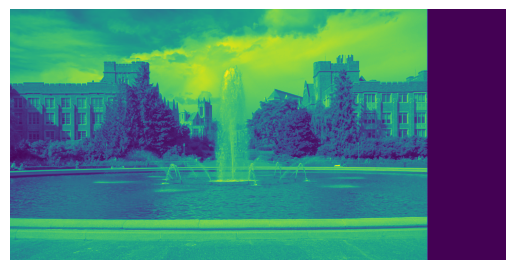

In [ ]:
plt.imshow(image_matching(images[1], images[0]))
plt.axis('off')
plt.show()

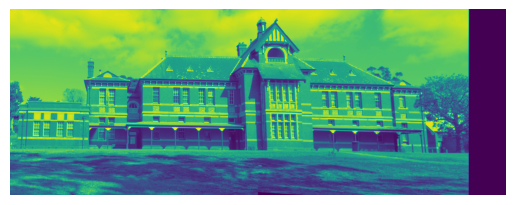

In [ ]:
plt.imshow(image_matching(images[3], images[2]))
plt.axis('off')
plt.show()